# Laser modelling

The laser is modeled as outlined in "Particle Image Velocimetry: A Practical Guide" by Raffel et al.-

The laser width definition is a difficult parameter. Per definition, the laser beam shape is based on a Gaussian distribution with a shape factor (shape factor of 1 (**Raffel et al. claims that it must be equal to 2, but this is not correct!**) is a Gaussian profile, larger values will result in more top-hat shaped beams). The laser width $\Delta Z0$ is where the (normalized) intensity drops to $-1/\sqrt{2\pi} \approx 0.67$:

\begin{equation}
I_0(Z) = q \cdot exp\left[ -\frac{1}{\sqrt{(2\pi)}} \left( \frac{2 Z^2}{\Delta Z_0^2} \right)^s \right]
\end{equation}

The laser width is $\Delta Z$ and the shape factor is $s$. However, this is not the physical width! Why? Let's build a 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import synpivimage

## Gaussian vs. top-hat laser sheet profile

Shape factor $s$=1 is a Gaussian laser sheet profile. To get a top-hat-like profile, use larger values, e.g. $s=10$ or higher.
In the below example, both sheets have a width of $\Delta Z=1$, but note its definition!

In [2]:
z = np.linspace(-2, 2, 10000)
gauss_laser = synpivimage.Laser(
    width=1,
    shape_factor=1
)
tophat_laser = synpivimage.Laser(
    width=1,
    shape_factor=10
)

Position particles

In [3]:
many_particles = synpivimage.Particles(
    x=np.ones_like(z),
    y=np.ones_like(z),
    z=z,
    size=np.ones_like(z)
)

In [4]:
gauss_iluminated_particles = gauss_laser.illuminate(many_particles)
tophat_iluminated_particles = tophat_laser.illuminate(many_particles)

In [5]:
import matplotlib.pyplot as plt

Notice how both laser beam profiles will intersect the same intensity at $I/I_0=0.67$

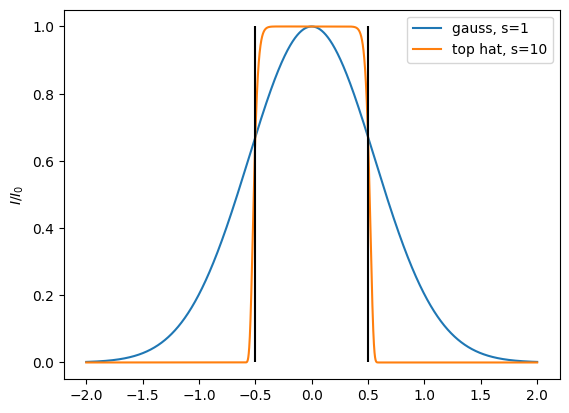

In [6]:
plt.plot(z, gauss_iluminated_particles.irrad_photons, label='gauss, s=1')
plt.plot(z, tophat_iluminated_particles.irrad_photons, label='top hat, s=10')
plt.vlines(-gauss_laser.width/2, 0, 1, color='k')
plt.vlines(gauss_laser.width/2, 0, 1, color='k')
plt.ylabel('$I/I_0$')
plt.legend()

Whether or not a particle will be illuminated (also outside $\Delta Z_0$) depends on the noise level. With no noise, the limit is set to $\exp(-2)$:

In [7]:
cam = synpivimage.Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=0,
    dark_noise=0,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=1.0
)

In [8]:
n = 400
many_particles = synpivimage.Particles(
    x=np.ones(n)*cam.nx//2,
    y=np.ones(n)*cam.ny//2,
    z=np.linspace(-3*gauss_laser.width / 2, 3*gauss_laser.width/2, n),
    size=np.ones(n)*2
)

In [9]:
imgOne, partOne = synpivimage.take_image(gauss_laser, cam, many_particles, particle_peak_count=1000)

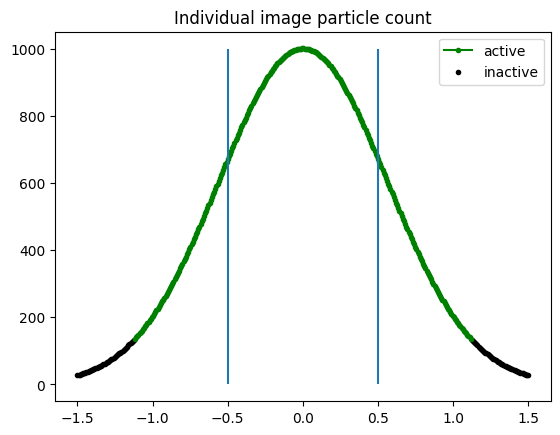

In [10]:
plt.plot(partOne.z[partOne.active], partOne.max_image_photons[partOne.active], marker='.', color='g', label='active')
plt.scatter(partOne.z[~partOne.active], partOne.max_image_photons[~partOne.active], marker='.', color='k', label='inactive')
plt.title('Individual image particle count')
plt.vlines(-gauss_laser.width/2, 0, 1000)
plt.vlines(gauss_laser.width/2, 0, 1000)
plt.legend()

# Influence of the noise level to the effective laser width

If the Gaussian noise (`dark_noise`) is larger than a particle than it cannot be seen, hence this defines the laser width:

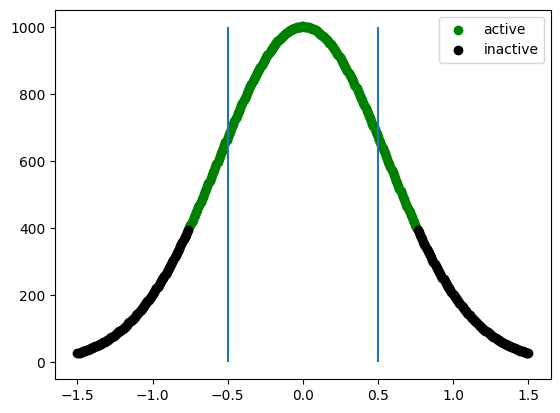

In [11]:
laser = synpivimage.Laser(
    width=1.0,
    shape_factor=1
)

cam = synpivimage.Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=200,
    dark_noise=100,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=1.0
)

many_particles.reset()
imgOne, partOne = synpivimage.take_image(laser, cam, many_particles, particle_peak_count=1000)


plt.scatter(partOne.z[partOne.active], partOne.max_image_photons[partOne.active], color='g', label='active')
plt.scatter(partOne.z[~partOne.active], partOne.max_image_photons[~partOne.active], color='k', label='inactive')
# plt.scatter(partOne.z[partOne.out_of_plane], partOne.max_image_photons[partOne.out_of_plane], color='y', label='inactive')
plt.vlines(-laser.width/2, 0, 1000)
plt.vlines(laser.width/2, 0, 1000)
plt.legend()

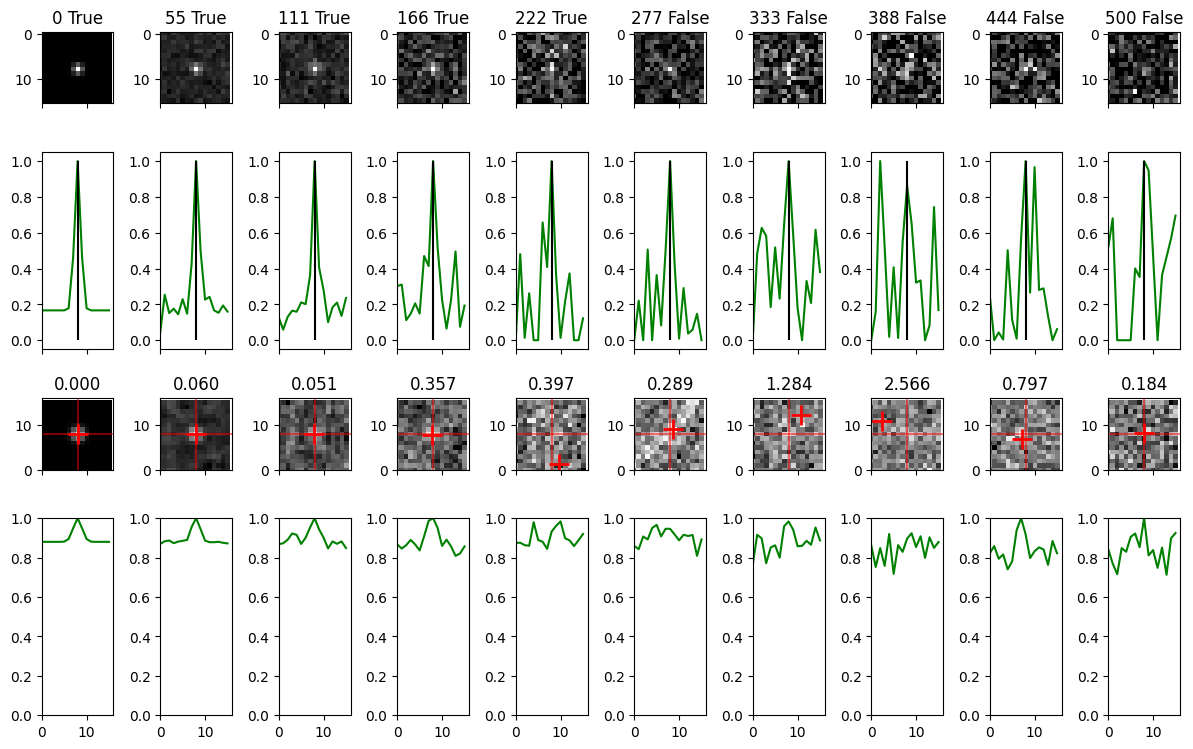

In [13]:
one_particle = synpivimage.Particles(
    x=[8, ],
    y=[8, ],
    z=[0, ],
    size=[2, ]
)

from scipy.fft import rfft2, irfft2, fftshift

def compute_fft_xcorr(imgA, imgB):
    """Computes the cross-correlation of two images using the Fourier method."""
    f2a = np.conj(rfft2(imgA))
    f2b = rfft2(imgB)
    return fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))

def get_integer_peak(corr):
    corr = np.asarray(corr)
    ind = corr.ravel().argmax(-1)
    peaks = np.array(np.unravel_index(ind, corr.shape[-2:]))

    peaks = np.vstack((peaks[0], peaks[1])).T
    index_list = [(i, v[0], v[1]) for i, v in enumerate(peaks)]
    # peaks_max = np.nanmax(corr, axis=(-2, -1))

    # np.array(index_list), np.array(peaks_max)
    iy, ix = index_list[0][2], index_list[0][1]
    return iy, ix
    
def gauss3pt(arr):
    """assuming highest peak is at the center of the array"""
    assert arr.shape == (3, 3), f'Wrong shape {arr.shape}'
    cl = arr[1, 0]
    cc = arr[1, 1]
    cr = arr[1, 2]
    cu = arr[2, 1]
    cd = arr[0, 1]

    nom1 = np.log(cl) - np.log(cr)
    den1 = 2 * np.log(cl) - 4 * np.log(cc) + 2 * np.log(cr)
    nom2 = np.log(cd) - np.log(cu)
    den2 = 2 * np.log(cd) - 4 * np.log(cc) + 2 * np.log(cu)
    subp_peak_position = (
        1 + np.divide(nom2, den2, out=np.zeros(1), where=(den2 != 0.0))[0],
        1 + np.divide(nom1, den1, out=np.zeros(1), where=(den1 != 0.0))[0]
    )
    return subp_peak_position

N = 10
fig, axs = plt.subplots(4, N, tight_layout=True, sharex=True,
                       figsize=(12, 8))

cam.particle_image_diameter = 2.5
for ii, dark_noise in enumerate(np.linspace(0, 500, N, dtype=int)):
    cam.dark_noise = dark_noise
    A, partA = synpivimage.take_image(laser, cam, one_particle, particle_peak_count=1000)
    B, partB = synpivimage.take_image(laser, cam, one_particle, particle_peak_count=1000)

    ny, nx = A.shape
    
    axs[0][ii].set_title(str(dark_noise)+' '+str(partA.active[0]))
    axs[0][ii].imshow(A, cmap='gray')
    axs[1][ii].plot(A[8, :]/A[8, :].max(), color='g')
    # axs[1][ii].plot(imgOne[:, 8]/imgOne[:, 8].max(), color='r')
    axs[1][ii].vlines(8, 0, 1, color='k')

    # compute auto correlation
    auto_corr = compute_fft_xcorr(A[:], B[:])
    j, i = get_integer_peak(auto_corr)
    
    # get peak position
    if j == 0:
        j = 1
    elif j == ny:
        j = ny - 3
    elif j == ny-1:
        j = ny - 2
    if i == 0:
        i = 1
    elif i == nx:
        i = nx - 3
    elif i == nx-1:
        i = nx - 2

    j0, i0 = gauss3pt(auto_corr[j-1:j+2, i-1:i+2])
    dist = np.sqrt((j0-1)**2+(i0-1)**2)
    
    # if i==0:
    corr_norm = auto_corr.max()
    axs[2][ii].imshow(auto_corr/corr_norm, cmap='gray')
    axs[2][ii].vlines(8, 0, 16, color='r', alpha=0.5)
    axs[2][ii].hlines(8, 0, 16, color='r', alpha=0.5)
    axs[2][ii].scatter(i0+i-1, j0+j-1, marker='+', color='r', s=200, linewidths=2)
    axs[2][ii].set_title(f'{dist:.3f}')
    axs[2][ii].set_xlim([0, 16])
    axs[2][ii].set_ylim([0, 16])
    
    axs[3][ii].plot(auto_corr[8, :]/corr_norm, color='g')
    axs[3][ii].set_ylim([0, 1])
    # axs[3][i].plot(auto_corr[:, 8]/corr_norm, color='r')

## Find a noise level at which the autocorrelation shows no detectable peak

In [ ]:
N = 100
M = 100
dists = np.zeros(shape=(N, M))
for ii, dark_noise in enumerate(np.linspace(0, 400, N, dtype=int)):
    for m in range(M):
        cam.dark_noise = dark_noise
        A, partA = synpivimage.take_image(laser, cam, one_particle, particle_peak_count=1000)
        B, partB = synpivimage.take_image(laser, cam, one_particle, particle_peak_count=1000)
        
        auto_corr = compute_fft_xcorr(A[:], B[:])
        
        j, i = get_integer_peak(auto_corr)
        
        # get peak position
        if j == 0:
            j = 1
        elif j == ny:
            j = ny - 3
        elif j == ny-1:
            j = ny - 2
            
        if i == 0:
            i = 1
        elif i == nx:
            i = nx - 3
        elif i == nx-1:
            i = nx - 2

        j0, i0 = gauss3pt(auto_corr[j-1:j+2, i-1:i+2])
        dist = np.sqrt((j0-1)**2+(i0-1)**2)

        dists[ii][m] = dist

In [ ]:
means = dists.mean(axis=1)
stds = dists.std(axis=1)

In [ ]:
# plt.errorbar(x=np.linspace(0, 1000, N, dtype=int), y=means, yerr=stds)
plt.plot(np.linspace(0, 400, N, dtype=int), means)
plt.hlines(0.5, 0, 400, color='k', linestyle='--')
plt.xlabel('dark noise')
plt.ylabel('dist to (0 | 0)')
plt.yscale('log')